In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
import genomeview
from pybedtools import BedTool
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [ ]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
peak_path = project_path + '/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.annotated_peaks.tsv'
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)
peak_df.head()

In [ ]:
ce = color_encoder()
colors = simpsons_palette()
#colors.extend(['black','white'])
random.seed(12)
colors = random.sample(colors, k = len(peak_df.sense_gtype.unique()))
ce.fit(peak_df.sense_gtype, colors)
ce.encoder = {'Long RNA': '#370335',
     'RBP': '#91331F',
     'Repeats': '#197EC0',
     'Unannotated': '#46732E',
     'miRNA': '#FD7446',
     'misc RNA': '#FD8CC1',
     'tRF3':'black',
     'tRF5':'black',
     'piRNA': '#D5E4A2',
     'snRNA': '#8A9197',
     'snoRNA': '#FED439'}

peak_df\
        .assign(peak_count = 1)\
        .groupby(['sense_gtype', 'pileup'], as_index=False)\
        .agg({'peak_count':'sum'}) \
        .sort_values('pileup')\
        .reset_index() \
        .assign(cum_count = lambda d: d.groupby('sense_gtype').peak_count.cumsum())\
        .assign(log_pile = lambda d: d.pileup.transform(np.log10))\
        .query('sense_gtype == "Long RNA"')

In [ ]:
peak_df\
    .query('pileup >= %i & sample_count > %i' %(pileup_cutoff, sample_cutoff))\
    .query('sense_gtype == "RBP"')\
    .sort_values('pileup', ascending=False)\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand)))\
    .assign(is_mt = lambda d: d.seq.map(is_mt))

In [9]:
peak_df.sense_gtype.unique()

array(['snRNA', 'RBP', 'Long RNA', 'Unannotated', 'misc RNA', 'snoRNA',
       'Repeats', 'miRNA', 'tRF3', 'piRNA', 'tRF5'], dtype=object)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_figure.pdf


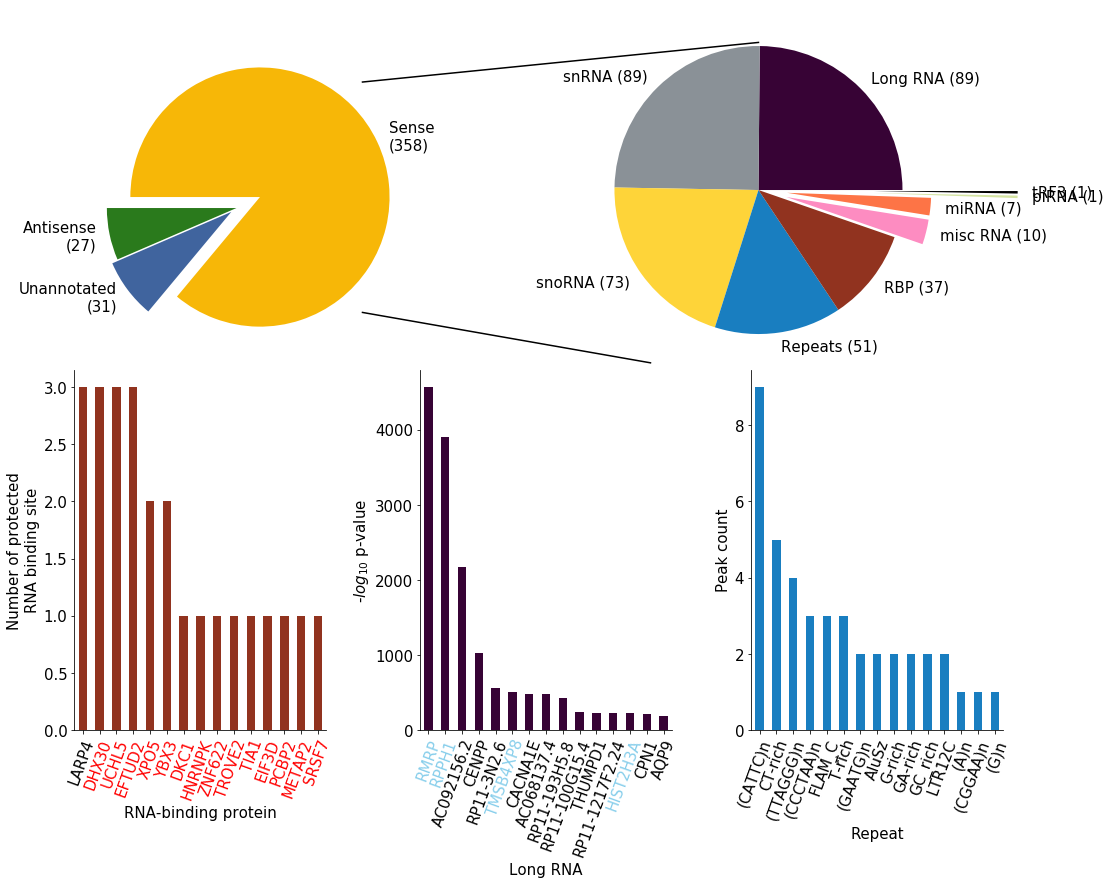

In [10]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.6, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
l1 = mlines.Line2D([0.3,0.85],[0.9,0.955], color= 'black',
                   figure = fig,  transform=fig.transFigure)
l2 = mlines.Line2D([0.3,0.7],[0.58,0.51], color= 'black',
                   figure = fig,  transform=fig.transFigure)
fig.lines.extend([l1, l2])
figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [22]:
peak_df.query('sense_gtype=="Long RNA"')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
12,chr9,35657742,35658018,unfragmented.rvs_peak_21459,45607,1078.74915,4567.49023,4560.78662,1113.0,13,RMRP,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
15,chr14,20811226,20811574,unfragmented.rvs_peak_6094,38983,962.66785,3904.95923,3898.39575,1012.0,13,RPPH1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
21,chr2,140977935,140978004,unfragmented.rvs_peak_11840,21664,511.72336,2172.87769,2166.49268,517.0,13,AC092156.2,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
28,chr9,95301666,95301808,unfragmented.fwd_peak_22401,10183,259.76184,1024.66833,1018.36090,262.0,11,CENPP,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense
49,chr7,63571925,63571997,unfragmented.rvs_peak_19427,5475,150.03883,553.44427,547.50531,151.0,13,RP11-3N2.6,Long RNA,-,RP11-165H4.1,Long RNA,0.000000e+00,0.000000e+00,Sense
56,chr2,131029982,131030053,unfragmented.fwd_peak_12076,4721,141.12009,478.22864,472.19611,144.0,10,AC068137.4,Long RNA,+,nmt-tRNA-Gln-TTG-7-1-tRF3,tRF3,0.000000e+00,0.000000e+00,Sense
52,chr4,91759633,91760266,unfragmented.rvs_peak_15996,4987,137.31573,504.66000,498.75940,138.0,13,AC019188.1,Long RNA,-,CCSER1,Long RNA,0.000000e+00,0.000000e+00,Sense
55,chr1,181391920,181392117,unfragmented.fwd_peak_1604,4750,135.69624,481.12512,475.09064,137.0,13,CACNA1E,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense
59,chr1,238105789,238105861,unfragmented.rvs_peak_2030,4234,127.66264,429.26782,423.43698,130.0,8,RP11-193H5.8,Long RNA,-,nmt-tRNA-Pro-TGG-1-1-tRF5,tRF5,0.000000e+00,0.000000e+00,Sense
86,chr1,149824232,149824685,unfragmented.fwd_peak_1305,2170,76.77817,222.82549,217.01976,80.0,13,HIST2H3A,Long RNA,+,.,Unannotated,1.494548e-223,6.448085e-221,Sense


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


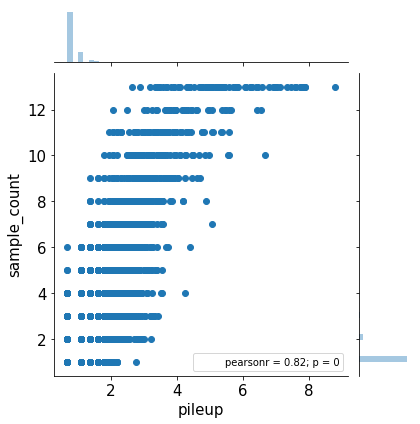

In [12]:
sns.jointplot(peak_df.pileup.transform(np.log),
            peak_df.sample_count)

In [13]:
','.join(rbp_df.head(15).index)

'LARP4,DHX30,UCHL5,EFTUD2,XPO5,YBX3,DKC1,HNRNPK,ZNF622,TROVE2,TIA1,EIF3D,PCBP2,METAP2,SRSF7'

In [14]:
peak_df \
    .query('pileup >= %i & sample_count > %i' %(pileup_cutoff, sample_cutoff))\
    .query('sense_gtype == "RBP"')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
10,chr6,95156833,95156909,unfragmented.rvs_peak_18402,51439,1202.69873,5150.76953,5143.98975,1241.0,13,MTPAP,RBP,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
25,chr19,11333579,11333670,unfragmented.rvs_peak_10114,11793,307.96194,1185.51001,1179.31689,313.0,13,EFTUD2,RBP,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
44,chr8,77557752,77557879,unfragmented.rvs_peak_20761,5968,161.02492,602.85028,596.86951,162.0,13,GNL3,RBP,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
45,chr8,68497628,68497832,unfragmented.rvs_peak_20705,5845,158.06126,590.48785,584.51288,159.0,12,"DHX30,GRSF1",RBP,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
69,chr9,5098270,5098342,unfragmented.fwd_peak_21962,2831,86.49294,289.05447,283.17972,87.0,9,DHX30,RBP,+,.,Unannotated,8.821247e-290,4.609298e-287,Sense
72,chr11,63978562,63978746,unfragmented.fwd_peak_3849,2644,83.21544,270.29611,264.43997,84.0,11,DDX24,RBP,+,.,Unannotated,5.056966e-271,2.529935e-268,Sense
131,chr16,2149771,2149861,unfragmented.rvs_peak_7658,1062,38.19717,111.73728,106.25568,38.0,11,EFTUD2,RBP,-,.,Unannotated,1.831133e-112,5.348616e-110,Sense
145,chr17,39913787,39913885,unfragmented.rvs_peak_8848,913,33.35732,96.79488,91.35899,33.0,13,XPO5,RBP,-,.,Unannotated,1.603688e-97,4.189814e-95,Sense
154,chr14,94847292,94847499,unfragmented.rvs_peak_6646,868,33.13382,92.29167,86.88496,33.0,9,TBRG4,RBP,-,.,Unannotated,5.108931e-93,1.271205e-90,Sense
173,chr15,91423004,91423098,unfragmented.fwd_peak_7629,765,29.34448,81.96136,76.50768,29.0,11,XPO5,RBP,+,.,Unannotated,1.093050e-82,2.436154e-80,Sense


In [15]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


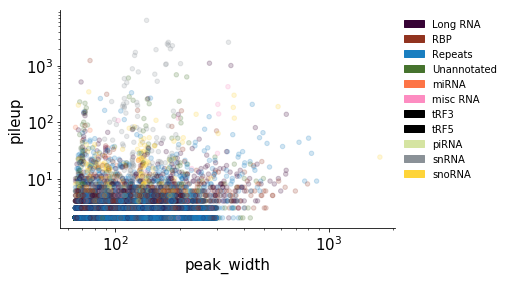

In [16]:
ax = plt.subplot()
pdf = peak_df\
    .pipe(lambda d: d[~d.sense_gtype.str.contains('tRF')])\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))

pdf.plot.scatter('peak_width','pileup', 
                  color = ce.transform(pdf.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


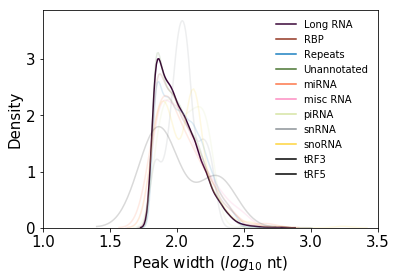

In [17]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: np.log10(d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 0.15
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width ($log_{10}$ nt)')

x_range = np.arange(1,4, 0.5)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plotted:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_qc.pdf


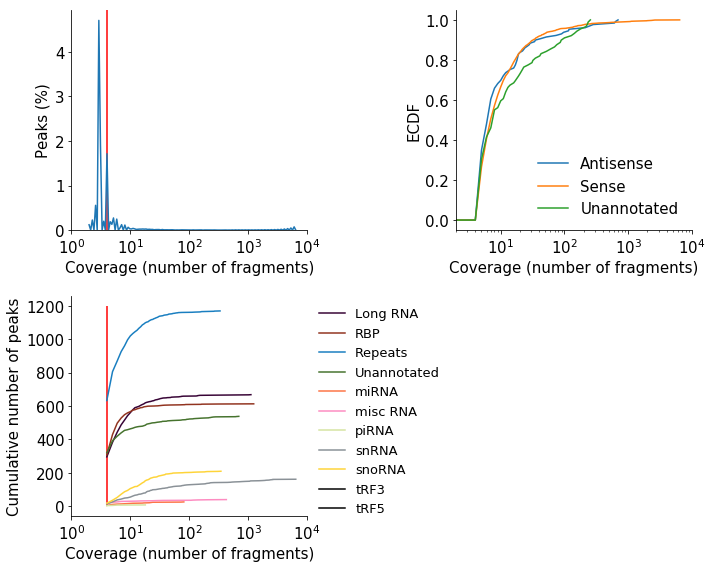

In [48]:
fig = plt.figure(figsize=(10,8))
cov_ax = fig.add_subplot(221)
number_ax = fig.add_subplot(223)
dist_cov_ax = fig.add_subplot(222)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [50]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
12,chr9,35657742,35658018,unfragmented.rvs_peak_21459,45607,1078.74915,4567.49023,4560.78662,1113.0,13,RMRP,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
15,chr14,20811226,20811574,unfragmented.rvs_peak_6094,38983,962.66785,3904.95923,3898.39575,1012.0,13,RPPH1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
21,chr2,140977935,140978004,unfragmented.rvs_peak_11840,21664,511.72336,2172.87769,2166.49268,517.0,13,AC092156.2,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
28,chr9,95301666,95301808,unfragmented.fwd_peak_22401,10183,259.76184,1024.66833,1018.36090,262.0,11,CENPP,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense
49,chr7,63571925,63571997,unfragmented.rvs_peak_19427,5475,150.03883,553.44427,547.50531,151.0,13,RP11-3N2.6,Long RNA,-,RP11-165H4.1,Long RNA,0.000000e+00,0.000000e+00,Sense
52,chr4,91759633,91760266,unfragmented.rvs_peak_15996,4987,137.31573,504.66000,498.75940,138.0,13,AC019188.1,Long RNA,-,CCSER1,Long RNA,0.000000e+00,0.000000e+00,Sense
55,chr1,181391920,181392117,unfragmented.fwd_peak_1604,4750,135.69624,481.12512,475.09064,137.0,13,CACNA1E,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense
56,chr2,131029982,131030053,unfragmented.fwd_peak_12076,4721,141.12009,478.22864,472.19611,144.0,10,AC068137.4,Long RNA,+,nmt-tRNA-Gln-TTG-7-1-tRF3,tRF3,0.000000e+00,0.000000e+00,Sense
59,chr1,238105789,238105861,unfragmented.rvs_peak_2030,4234,127.66264,429.26782,423.43698,130.0,8,RP11-193H5.8,Long RNA,-,nmt-tRNA-Pro-TGG-1-1-tRF5,tRF5,0.000000e+00,0.000000e+00,Sense
80,chr9,94872791,94872858,unfragmented.fwd_peak_22396,2394,72.99653,245.29840,239.46759,73.0,10,RP11-100G15.4,Long RNA,+,SPTLC1,Long RNA,5.030371e-246,2.319248e-243,Sense


In [49]:
anti_peaks.antisense_gtype.unique()

array(['RBP', 'Long RNA', 'snRNA', 'snoRNA', 'piRNA', 'misc RNA', 'miRNA'],
      dtype=object)

In [20]:
anti_peaks = peak_df.query('is_sense == "Antisense"')\
    .pipe(lambda d: d[~d.antisense_gtype.str.contains('tRF')])

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plotted:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_anti.pdf


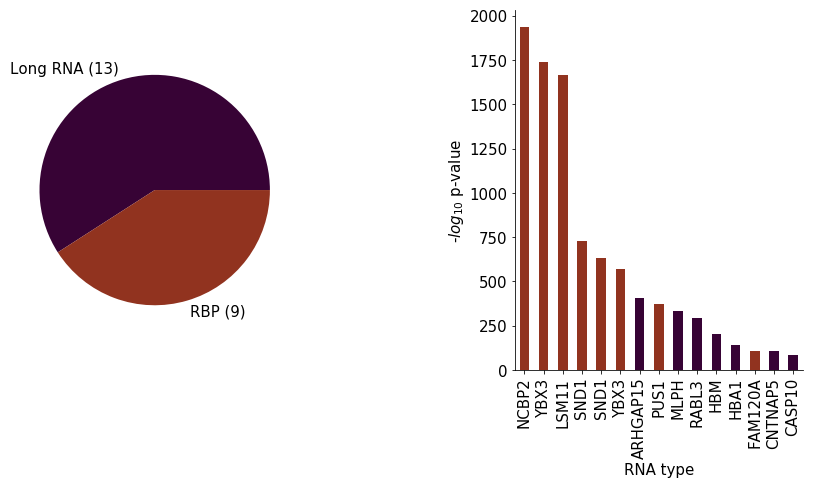

In [21]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0.1,0.4,0.8])
plot_peak_pie(anti_peaks, ax, ce, gtype='antisense_gtype')
ax = fig.add_axes([0.7, 0, 0.4, 1])
anti_plot = anti_peaks.nlargest(15, 'log10p')
anti_plot.plot\
    .bar('antisense_gname', 'log10p', 
         color = ce.transform(anti_plot\
                               .antisense_gtype),
        ax = ax)
ax.legend().set_visible(False)
ax.set_xlabel('RNA type')
ax.set_ylabel('-$log_{10}$ p-value')
sns.despine()
fig.tight_layout()
figurename = figure_path + '/peak_anti.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [34]:
bam_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bam'
ref_path = '/stor/work/Lambowitz/ref/hg19'
tracks = {'DNase I': bam_path + '/unfragmented.bam',
         'NaOH': bam_path + '/alkaline_hydrolysis.bam',
         'sncRNA': ref_path + '/new_genes/sncRNA_viz.bed',
         'Protein': ref_path + '/new_genes/genes.bed12.bed'}
genome = ref_path + '/genome/hg19_genome.fa'

def color_func(interval):
    return 'salmon' if get_strand(interval.read) == '+' else 'steelblue'

regions = 'chr14:50329268-50329569'
matches = re.search('(chr[0-9XY]+):([0-9]+)-([0-9]+)', regions)
chrom, start, end = matches.groups()

viz = genomeview.visualize_data(tracks, chrom, int(start)-400, int(end)+400, genome)
for track in ['DNase I', 'NaOH']:
    tr = genomeview.get_one_track(viz, track)
    tr.color_fn = color_func
    if track == "DNase I":
        tr.row_height = 0.02

viz

In [35]:
fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
fa.fetch('chr12',22158771,22158870)

'TTTACCCAAATAAAGTATAGGTGATAGAAATTGTATCTTGACGCAATAGATATAGTACCGCAAGGGAAAGATGACAAAACATAACCAAGCATAAAATAG'

In [36]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
intron_df = BedTool()\
    .from_dataframe(peak_df )\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8,wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-



(252, 23)

In [37]:
intron_df \
    .query('pileup >= 5' )

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,...,antisense_gtype,pvalue,FDR,is_sense,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand
0,chr19,11333582,11333668,unfragmented.rvs_peak_50752,9366,253.80643,942.69574,936.65271,299.0,EFTUD2,...,Unannotated,0.000000e+00,0.000000e+00,Sense,chr19,11333582,11333668,ENSG00000130158.9,0,-
1,chr22,50356514,50356587,unfragmented.fwd_peak_74339,1242,42.22908,129.87506,124.23650,52.0,MIR6821,...,Unannotated,1.333337e-130,5.006845e-127,Sense,chr22,50356514,50356587,ENSG00000198355.4,0,+
2,chr17,39913789,39913885,unfragmented.rvs_peak_44551,811,30.00123,86.48480,81.10771,32.0,XPO5,...,Unannotated,3.274915e-87,9.294779e-84,Sense,chr17,39913789,39913885,ENSG00000173801.12,0,-
3,chr16,15027134,15027223,unfragmented.fwd_peak_41446,782,31.52192,83.73048,78.22795,32.0,RP11-958N24.1,...,Unannotated,1.860030e-84,5.101143e-81,Sense,chr16,15027134,15027223,ENSG00000183426.11,0,+
4,chr16,2149772,2149861,unfragmented.rvs_peak_38363,781,30.07980,83.57507,78.14968,31.0,EFTUD2,...,Unannotated,2.660296e-84,7.214812e-81,Sense,chr16,2149772,2149861,ENSG00000008710.13,0,-
5,chr16,18430618,18430707,unfragmented.rvs_peak_39282,590,24.21262,64.31211,59.06322,25.0,RP11-1212A22.1,...,Unannotated,4.874050e-65,1.052808e-61,Sense,chr16,18430618,18430707,ENSG00000214940.4,0,-
6,chr16,18470720,18470809,unfragmented.rvs_peak_39289,406,18.26798,45.83761,40.69362,18.0,RP11-1212A22.4,...,Unannotated,1.453416e-46,2.027167e-43,Sense,chr16,18470720,18470809,ENSG00000233024.3,0,-
7,chr17,73500562,73500652,unfragmented.rvs_peak_46298,386,16.94794,43.73572,38.62443,17.0,CASKIN2,...,Unannotated,1.837723e-44,2.411596e-41,Sense,chr17,73500562,73500652,ENSG00000177303.5,0,-
8,chr17,48216682,48216793,unfragmented.rvs_peak_45104,321,14.79634,37.17871,32.15405,15.0,PRPF8,...,Long RNA,6.626588e-38,7.063046e-35,Sense,chr17,48216682,48216793,ENSG00000108819.9,0,-
9,chr2,97529532,97529662,unfragmented.rvs_peak_57479,311,14.20104,36.17538,31.16733,15.0,LIN28B,...,Unannotated,6.677594e-37,7.025376e-34,Sense,chr2,97529532,97529662,ENSG00000168758.6,0,-


In [60]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []
fa = pysam.Fastafile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
def fetch_seq(chrom, start, end, strand):
    intron_seq = fa.fetch(chrom, start - 1, end)
    intron_seq = intron_seq if strand == "+" else reverse_complement(intron_seq)
    return intron_seq
    
    

intron_df = intron_df.query('pileup >=3') \
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
intron_df.head()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,...,FDR,is_sense,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand,seq,dinucleotide
0,chr19,11333582,11333668,unfragmented.rvs_peak_7689,8779,245.78587,883.93384,877.97772,286.0,EFTUD2,...,0.000000e+00,Sense,chr19,11333582,11333668,ENSG00000130158.9,0,-,GTAGGAGTGGGCGTGGGCAGGGTGGGCATGGCATGGATGGAAGGCG...,GT:AG
1,chr17,39913789,39913885,unfragmented.rvs_peak_6736,729,28.46350,78.24293,72.95807,30.0,XPO5,...,1.765379e-76,Sense,chr17,39913789,39913885,ENSG00000173801.12,0,-,GTGAGCTGGGGGAGGGCAGGAGGCTGGGTCCCACTCCCCCAGCCAC...,GT:AG
2,chr16,2149772,2149861,unfragmented.rvs_peak_5807,714,28.12118,76.77870,71.48138,28.0,EFTUD2,...,4.853330e-75,Sense,chr16,2149772,2149861,ENSG00000008710.13,0,-,GTGGGTGCCGTAGGGGTCGGGGCAGCCTCTTCCTGCCCAGCCCTTC...,GT:AG
3,chr16,15027134,15027223,unfragmented.fwd_peak_6415,685,29.01322,73.82935,68.50440,30.0,RP11-958N24.1,...,4.185142e-72,Sense,chr16,15027134,15027223,ENSG00000183426.11,0,+,GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTC...,GT:AG
4,chr15,91423005,91423096,unfragmented.fwd_peak_6191,538,22.24964,59.07255,53.84354,23.0,XPO5,...,1.976857e-57,Sense,chr15,91423005,91423096,ENSG00000140564.6,0,+,GTGAGGGCAGGCTGGCCCGGCAGGCTGGATGTGGAGTTAGGTAGAA...,GT:AG


In [63]:
tablename = figure_path + '/intron_table.csv'
intron_df \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

Written:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/intron_table.csv


In [46]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,...,pvalue,FDR,is_sense,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand,length
count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: 'DataFrame' object has no attribute 'gid'

In [48]:
glist

NameError: name 'glist' is not defined

In [49]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



NameError: name 'glist' is not defined

NameError: name 'glist' is not defined

In [50]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

NameError: name 'peaks' is not defined

In [51]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

NameError: name 'peaks' is not defined

In [52]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

NameError: name 'peaks' is not defined

In [53]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

NameError: name 'peaks' is not defined

In [54]:
import gseapy as gsp

In [55]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

2018-09-09 18:07:22,999 Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-54e17a5d030f>", line 2, in <module>
    gene_sets = 'KEGG_2016')
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/gseapy/gsea.py", line 953, in prerank
    pre.run()
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/gseapy/gsea.py", line 432, in run
    gmt = self.load_gmt(gene_list=dat2.index.values, gmt=self.gene_sets)
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/gseapy/gsea.py", line 93, in load_gmt
    genesets_dict = self.parse_gmt(gmt)
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/gseapy/gsea.py", line 138, in parse_gmt
    return self._download_libraries(gmt)
  File "/stor/work/Lambowitz/cdw2854/src/min

KeyboardInterrupt: 

In [ ]:
res.res2d

'ACCACGGCCGTTGAACATATGTCACTGGGCAGGCAGTGCCTCTACTACTGGTAATGCTAGCGGTGATGTTTTTGGTAAACAAGCTGGGTAAGATTTGCCGAGTTCCTTTTACTGTTTGTAATCTTTCCTTAGAGCATACCTGTGTTGGATTAACAGTAT'

In [131]:
aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
aln = aligner.map(fa.fetch('chr17',33981908,33982067))

In [132]:
print(next(aln))

0	148	-	chrM	16569	2426	2575	135	149	40	tp:A:P	ts:A:.	cg:Z:17M1D131M


In [40]:
def check_MT(peaks, return_column=False):
    mt = 0
    aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
    fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
    mts = []
    for peak_count, row in peaks.reset_index().iterrows():
        seq = fa.fetch(row['chrom'], row['start'], row['end'])
        seq = seq if row['strand'] == "+" else reverse_complement(seq)
    
        alns = aligner.map(seq)
        try:
            aln = next(alns)
            mt += 1
            mts.append('MT')
            #print(aln.cigar_str)
        except StopIteration:
            #print(row)
            mts.append('no')
            pass


    print('%i seq: %i in MT' %(peak_count, mt))
    if return_column:
        return mts

In [42]:
anti = peak_df.query('pileup >= 5').query('is_sense == "Unannotated"')
anti['MT'] = check_MT(anti, return_column=True)

82 seq: 4 in MT


In [44]:
peak_df.query("sense_gtype == 'tRF3'")

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
28026,chr1,238104447,238104679,unfragmented.fwd_peak_10673,24,2.66633,5.63692,2.40724,3.0,tRNA-Tyr-ATA-chr1-52-tRF3,tRF3,+,.,Unannotated,2.307172e-06,0.000016,Sense
5158,chr17,29877164,29877510,unfragmented.fwd_peak_46762,37,3.55599,7.41424,3.70360,3.0,tRNA-Thr-CGT-4-1-tRF3,tRF3,+,.,Unannotated,3.852654e-08,0.000001,Sense
109732,chr17,8022548,8022717,unfragmented.fwd_peak_45744,11,1.96892,3.90910,1.16075,1.0,tRNA-Lys-TTT-3-5-tRF3,tRF3,+,.,Unannotated,1.232821e-04,0.000231,Sense
